In [3]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import json

In [4]:
EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)


In [5]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select * from features', db_conn)
db_conn.close()


In [11]:
len(sequences_df)

564179

In [6]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'peak_idx', 'target_coords',
       'theoretical_mz', 'q_value', 'delta_mz_ppm', 'delta_rt', 'delta_scan',
       'fwhm_rt_0', 'fwhm_scan_0', 'geometric_mean_0_1',
       'geometric_mean_0_1_2', 'isotope_0_1_mz_delta_ppm',
       'isotope_0_1_rt_delta', 'isotope_0_1_scan_delta',
       'isotope_0_2_mz_delta_ppm', 'isotope_0_2_rt_delta',
       'isotope_0_2_scan_delta', 'monoisotope_auc_over_isotope_peak_auc_sum',
       'monoisotope_int_over_isotope_peak_int_sum', 'mz_delta_ppm_std_dev_0',
       'mz_delta_ppm_std_dev_1', 'number_of_frames_0', 'number_of_frames_1',
       'number_of_frames_2', 'number_of_missing_frames_0',
       'number_of_missing_frames_1', 'number_of_missing_frames_2',
       'peak_base_width_rt_0', 'peak_base_width_scan_0', 'r_squared_phr',
       'rt_isotope_correlation', 'rt_peak_symmetry_0', 'rt_peak_symmetry_1',
       'rt_peak_symmetry_2', 'scan_isotope_correlation',
       'scan_peak_symmetry_0', 'scan_peak_symmetry_1'

In [10]:
sequences_df.number_of_runs_extracted.max()

20

In [7]:
modified_sequences_count = len(sequences_df['sequence'].unique())

In [12]:
sequence_occurences_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df)))
sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['group','frequency'])

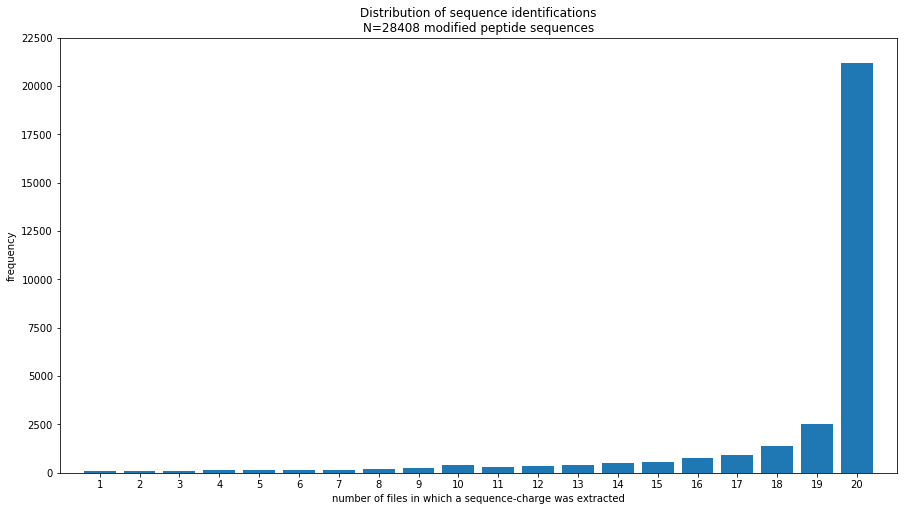

In [13]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Distribution of sequence identifications\nN={} modified peptide sequences'.format(modified_sequences_count))

counts = np.bincount(sequence_occurences_df.frequency)
ax1.bar(range(21), counts, width=0.8, align='center')
plt.xlabel('number of files in which a sequence-charge was extracted')
plt.ylabel('frequency')
ax1.set(xticks=range(1,21), xlim=[0, 21])
# plt.ylim((0,20000))

plt.show()

In [14]:
sequence_occurences_df['missing_files'] = 20 - sequence_occurences_df.frequency

In [15]:
proportion_of_missing_values = sequence_occurences_df.missing_files.sum() / (len(sequence_occurences_df) * 20)
proportion_of_missing_values

0.07807863259036538

In [17]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= 5) and (len(sequence_in_1to3_df) >= 5):
        average_intensity_in_1to1 = sequence_in_1to1_df.intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))

In [18]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [19]:
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 / sequence_occurences_in_batch_df.intensity_1to1

In [20]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

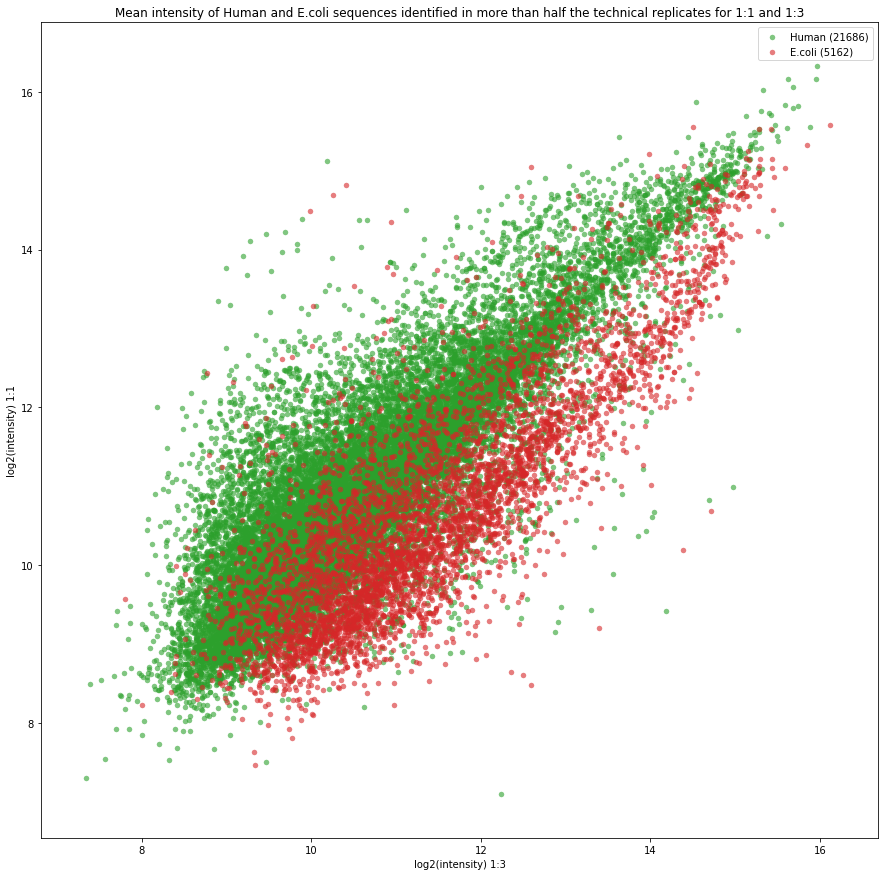

In [21]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(np.log2(human_df.intensity_1to3), np.log2(human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_1to3), np.log2(ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

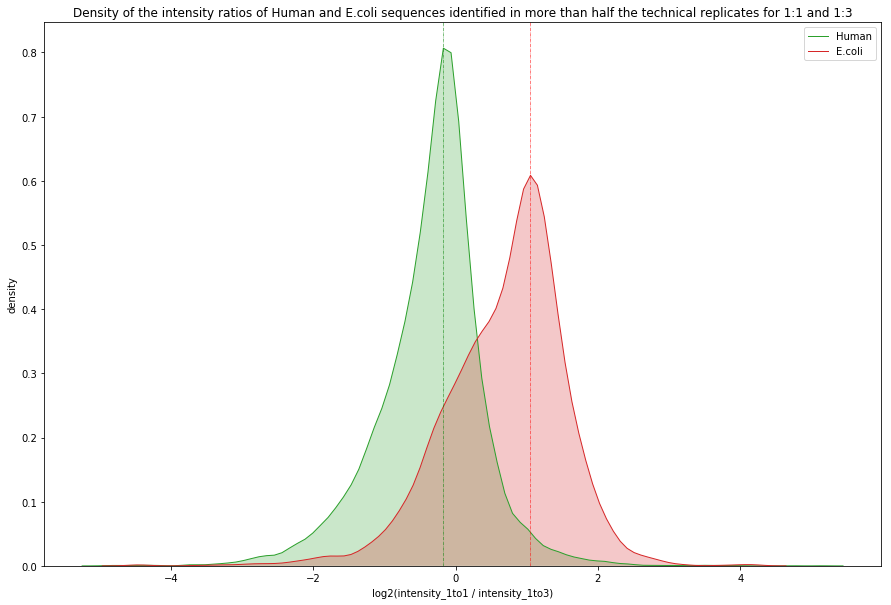

In [22]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')

In [23]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'peak_idx', 'target_coords',
       'theoretical_mz', 'q_value', 'delta_mz_ppm', 'delta_rt', 'delta_scan',
       'fwhm_rt_0', 'fwhm_scan_0', 'geometric_mean_0_1',
       'geometric_mean_0_1_2', 'isotope_0_1_mz_delta_ppm',
       'isotope_0_1_rt_delta', 'isotope_0_1_scan_delta',
       'isotope_0_2_mz_delta_ppm', 'isotope_0_2_rt_delta',
       'isotope_0_2_scan_delta', 'monoisotope_auc_over_isotope_peak_auc_sum',
       'monoisotope_int_over_isotope_peak_int_sum', 'mz_delta_ppm_std_dev_0',
       'mz_delta_ppm_std_dev_1', 'number_of_frames_0', 'number_of_frames_1',
       'number_of_frames_2', 'number_of_missing_frames_0',
       'number_of_missing_frames_1', 'number_of_missing_frames_2',
       'peak_base_width_rt_0', 'peak_base_width_scan_0', 'r_squared_phr',
       'rt_isotope_correlation', 'rt_peak_symmetry_0', 'rt_peak_symmetry_1',
       'rt_peak_symmetry_2', 'scan_isotope_correlation',
       'scan_peak_symmetry_0', 'scan_peak_symmetry_1'

In [26]:
cols = ['sequence','charge','file_idx','theoretical_mz','q_value','delta_mz_ppm','delta_rt','delta_scan','inferred','intensity','monoisotopic_mass','monoisotopic_mz_centroid','rt_apex','scan_apex','run_name','batch','human','number_of_runs_extracted']

In [29]:
cols.sort()
cols

['batch',
 'charge',
 'delta_mz_ppm',
 'delta_rt',
 'delta_scan',
 'file_idx',
 'human',
 'inferred',
 'intensity',
 'monoisotopic_mass',
 'monoisotopic_mz_centroid',
 'number_of_runs_extracted',
 'q_value',
 'rt_apex',
 'run_name',
 'scan_apex',
 'sequence',
 'theoretical_mz']

In [30]:
sequences_df[cols].to_csv('~/extracted-features.csv', index=False)